In [23]:
# Import packages and libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import time

## Part b

In [76]:
# Define functions

def pi(x1, x2):
  return np.exp(x1) / (np.exp(x1) + np.exp(x2))

def qi(x1, x2):
  return np.exp(x1 - np.maximum(x1, x2)) / (np.exp(x1 - np.maximum(x1, x2)) + np.exp(x2 - np.maximum(x1, x2)))

In [80]:
# Grid search
x1_list = np.arange(-1000, 1000, 20)
x2_list = np.arange(-1000, 1000, 20)
x1, x2 = np.meshgrid(x1_list, x2_list)
pi_result = pi(x1, x2)
qi_result = qi(x1, x2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


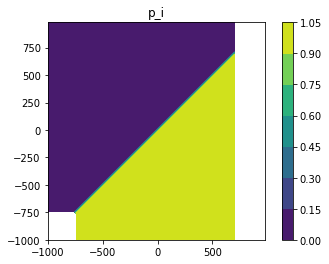

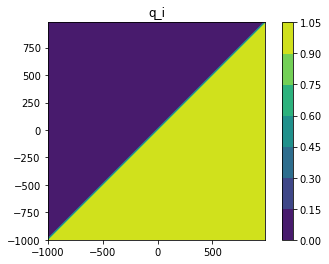

In [82]:
# Plots

plt.figure()
plt.contourf(x1_list, x2_list, pi_result)
plt.axis('scaled')
plt.colorbar()
plt.title('p_i')
plt.show()

plt.figure()
plt.contourf(x1_list, x2_list, qi_result)
plt.axis('scaled')
plt.colorbar()
plt.title('q_i')
plt.show()

The expression qi is better numerically since it avoids overflow.

## Part c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


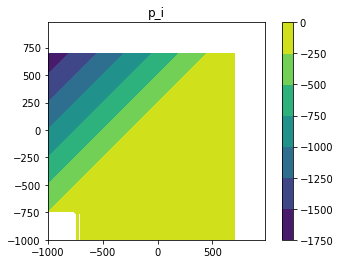

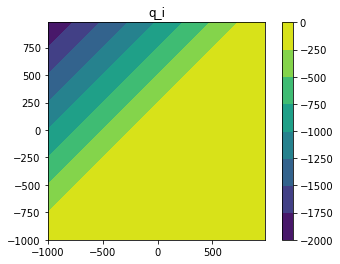

In [87]:
def pi_log(x1, x2):
  return x1 - np.log(np.exp(x1) + np.exp(x2))

def qi_log(x1, x2):
  return (x1 - np.maximum(x1, x2)) - np.log((np.exp(x1 - np.maximum(x1, x2)) + np.exp(x2 - np.maximum(x1, x2))))

pilog_result = pi_log(x1, x2)
qilog_result = qi_log(x1, x2)

plt.figure()
plt.contourf(x1_list, x2_list, pilog_result)
plt.axis('scaled')
plt.colorbar()
plt.title('p_i')
plt.show()

plt.figure()
plt.contourf(x1_list, x2_list, qilog_result)
plt.axis('scaled')
plt.colorbar()
plt.title('q_i')
plt.show()

Although it is known that log softmax can be advantageous because it can provide numerical stability, from the plots above we can see that using log does not increase the range of the evaluated functions.

# Problem 2

## Part a

In [2]:
# Define location of the data
train_data = torchvision.datasets.MNIST(root='/data/', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.MNIST(root='/data/', train=False, download=True, transform=torchvision.transforms.ToTensor())

# Create dataloader
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=60000,shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=10000,shuffle=True, num_workers=2)

In [3]:
# Define functions

def linear(x, w, b):
  return torch.matmul(x, w) + b

def softmax(z):
  return torch.div(torch.exp(z), torch.sum(torch.exp(z), dim=1).reshape(-1, 1))

def crossentropy(y, y_hat):
  return -torch.mean(torch.sum(y * torch.log(y_hat), dim=1))

def train_GD(epochs, lr, train_dataloader, test_dataloader):

  # Define dimensions
  d_in = 28 * 28
  d_out = 10
  batch_size_train = 60000
  train_loss_list = []
  train_err_list = []
  test_loss_list = []
  test_err_list = []
  epoch_list = []
  time_list = []

  # Initialize weights and biases
  w = torch.randn(d_in, d_out, dtype=torch.float)
  b = torch.zeros(1, d_out, dtype=torch.float)

  # Define device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # Start timer
  start_time = time.time()

  # Train
  for epoch in range(epochs):
    
    for phase in ['train', 'test']:

      if phase == 'train':
        dataloader = train_dataloader
      else:
        dataloader = test_dataloader

      inputs, labels = next(iter(dataloader))
      inputs = inputs.to(device)
      labels = labels.to(device)
      x = inputs.view(inputs.size(0), -1)
      labels = torch.nn.functional.one_hot(labels, num_classes=10) 

      # Forward
      z = linear(x, w, b)
      y_hat = softmax(z)

      # Loss
      loss = crossentropy(labels, y_hat).sum().item()

      if phase == 'train':

        # Backpropagration
        dz = (y_hat - labels) / batch_size_train
        w_grad = torch.matmul(x.t(), dz)
        b_grad = torch.sum(dz, dim=0)

        # Update parameters      
        w -= (lr * w_grad)
        b -= (lr * b_grad)

      # Compute accuracy training
      pred = torch.argmax(y_hat, dim=1)
      target = torch.argmax(labels, dim=1)
      corrects = (pred == target).sum().item()
      total = labels.shape[0]

      if phase == 'train':
        train_loss = loss / len(train_dataloader)
        train_loss_list.append(train_loss)
        train_acc = corrects / total
        train_err_list.append((1 - train_acc) * 100)
      else:
        test_loss = loss / len(test_dataloader)
        test_loss_list.append(test_loss)        
        test_acc = corrects / total
        test_err_list.append((1 - test_acc) * 100)
        epoch_list.append(epoch + 1)
        time_list.append(time.time() - start_time)

  return train_loss_list, test_loss_list, train_err_list, test_err_list, epoch_list, time_list

## Part b

In [4]:
# Train model
train_loss_list, test_loss_list, train_err_list, test_err_list, epoch_list, time_list = train_GD(100, 0.25, train_dataloader, test_dataloader)

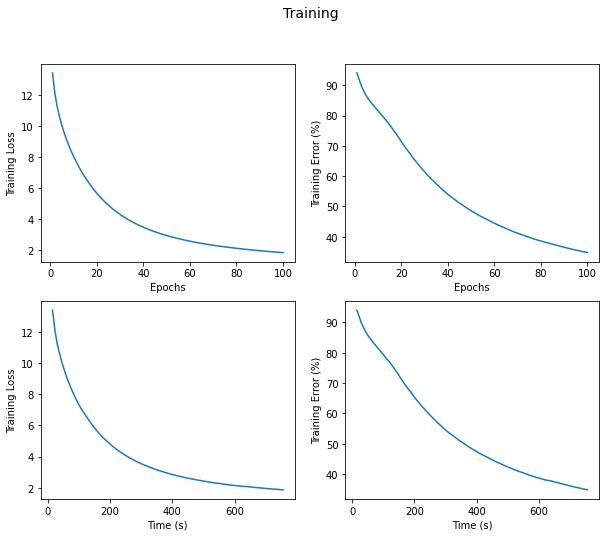

In [5]:
# Plot training

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.plot(epoch_list, train_loss_list)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

plt.subplot(2,2,2)
plt.plot(epoch_list, train_err_list)
plt.xlabel('Epochs')
plt.ylabel('Training Error (%)')

plt.subplot(2,2,3)
plt.plot(time_list, train_loss_list)
plt.xlabel('Time (s)')
plt.ylabel('Training Loss')

plt.subplot(2,2,4)
plt.plot(time_list, train_err_list)
plt.xlabel('Time (s)')
plt.ylabel('Training Error (%)')

plt.suptitle('Training', fontsize=14)
plt.show()

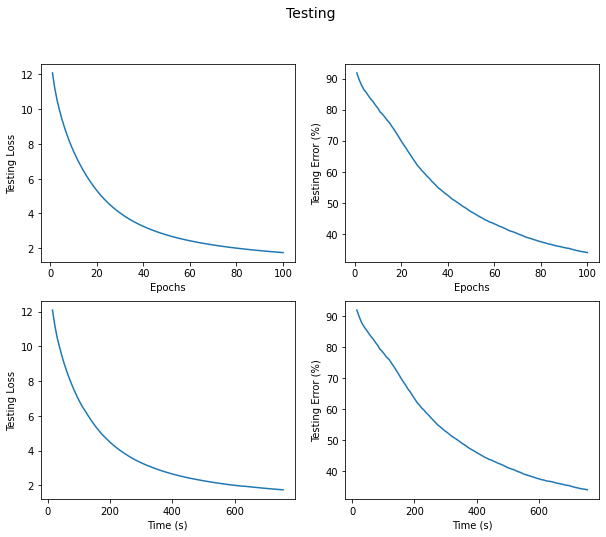

In [6]:
# Plot testing

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.plot(epoch_list, test_loss_list)
plt.xlabel('Epochs')
plt.ylabel('Testing Loss')

plt.subplot(2,2,2)
plt.plot(epoch_list, test_err_list)
plt.xlabel('Epochs')
plt.ylabel('Testing Error (%)')

plt.subplot(2,2,3)
plt.plot(time_list, test_loss_list)
plt.xlabel('Time (s)')
plt.ylabel('Testing Loss')

plt.subplot(2,2,4)
plt.plot(time_list, test_err_list)
plt.xlabel('Time (s)')
plt.ylabel('Testing Error (%)')

plt.suptitle('Testing', fontsize=14)
plt.show()

## Part c

In [7]:
# Create dataloader
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=100,shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=100,shuffle=True, num_workers=2)

In [8]:
# Define functions

def train_SGD(epochs, lr, train_dataloader, test_dataloader):

  # Define dimensions
  d_in = 28 * 28
  d_out = 10
  batch_size_train = 100
  train_loss_list = []
  train_err_list = []
  test_loss_list = []
  test_err_list = []
  epoch_list = []
  time_list = []

  # Initialize weights and biases
  w = torch.randn(d_in, d_out, dtype=torch.float)
  b = torch.zeros(1, d_out, dtype=torch.float)

  # Define device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # Start timer
  start_time = time.time()

  # Train
  for epoch in range(epochs):
    
    for phase in ['train', 'test']:

      loss = 0
      corrects = 0
      total = 0

      if phase == 'train':
        dataloader = train_dataloader
      else:
        dataloader = test_dataloader

      for i, data in enumerate(dataloader):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        x = inputs.view(inputs.size(0), -1)
        labels = torch.nn.functional.one_hot(labels, num_classes=10) 

        # Forward
        z = linear(x, w, b)
        y_hat = softmax(z)

        # Loss
        loss += crossentropy(labels, y_hat).sum().item()

        if phase == 'train':

          # Backpropagration
          dz = (y_hat - labels) / batch_size_train
          w_grad = torch.matmul(x.t(), dz)
          b_grad = torch.sum(dz, dim=0)

          # Update parameters      
          w -= (lr * w_grad)
          b -= (lr * b_grad)

        # Compute accuracy training
        pred = torch.argmax(y_hat, dim=1)
        target = torch.argmax(labels, dim=1)
        corrects += (pred == target).sum().item()
        total += labels.shape[0]

      if phase == 'train':
        train_loss = loss / len(train_dataloader)
        train_loss_list.append(train_loss)
        train_acc = corrects / total
        train_err_list.append((1 - train_acc) * 100)
      else:
        test_loss = loss / len(test_dataloader)
        test_loss_list.append(test_loss)        
        test_acc = corrects / total
        test_err_list.append((1 - test_acc) * 100)
        epoch_list.append(epoch + 1)
        time_list.append(time.time() - start_time)

  return train_loss_list, test_loss_list, train_err_list, test_err_list, epoch_list, time_list

## Part d

In [9]:
# Train model
train_loss_list, test_loss_list, train_err_list, test_err_list, epoch_list, time_list = train_SGD(100, 0.25, train_dataloader, test_dataloader)

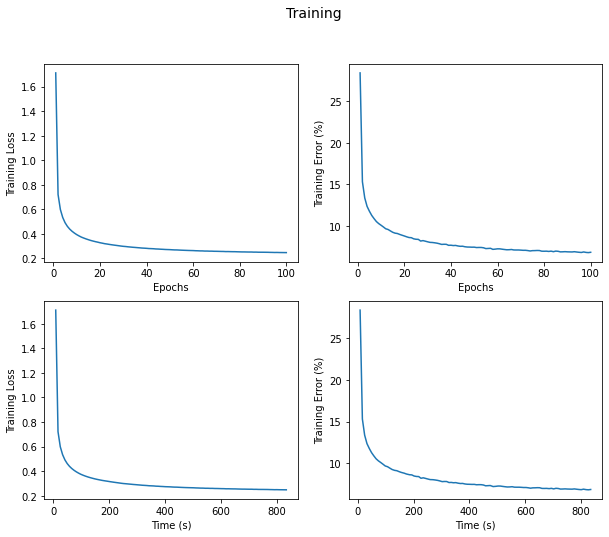

In [10]:
# Plot training

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.plot(epoch_list, train_loss_list)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

plt.subplot(2,2,2)
plt.plot(epoch_list, train_err_list)
plt.xlabel('Epochs')
plt.ylabel('Training Error (%)')

plt.subplot(2,2,3)
plt.plot(time_list, train_loss_list)
plt.xlabel('Time (s)')
plt.ylabel('Training Loss')

plt.subplot(2,2,4)
plt.plot(time_list, train_err_list)
plt.xlabel('Time (s)')
plt.ylabel('Training Error (%)')

plt.suptitle('Training', fontsize=14)
plt.show()

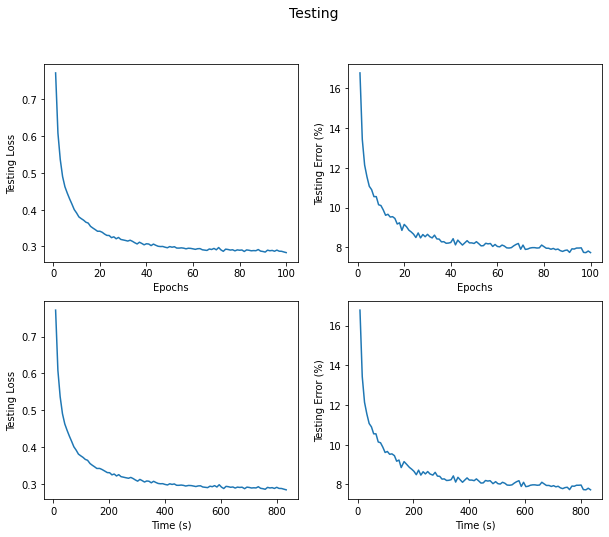

In [11]:
# Plot testing

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.plot(epoch_list, test_loss_list)
plt.xlabel('Epochs')
plt.ylabel('Testing Loss')

plt.subplot(2,2,2)
plt.plot(epoch_list, test_err_list)
plt.xlabel('Epochs')
plt.ylabel('Testing Error (%)')

plt.subplot(2,2,3)
plt.plot(time_list, test_loss_list)
plt.xlabel('Time (s)')
plt.ylabel('Testing Loss')

plt.subplot(2,2,4)
plt.plot(time_list, test_err_list)
plt.xlabel('Time (s)')
plt.ylabel('Testing Error (%)')

plt.suptitle('Testing', fontsize=14)
plt.show()

SGD does improve training and performance.

# Problem 3

## Part a

In [12]:
# Create dataloader
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=100,shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=100,shuffle=True, num_workers=2)

In [13]:
# Define functions

def train_SGD_mod(epochs, lr, train_dataloader, test_dataloader):

  # Define dimensions
  d_in = 1
  d_out = 10
  batch_size_train = 100
  train_loss_list = []
  train_err_list = []
  test_loss_list = []
  test_err_list = []
  epoch_list = []
  time_list = []

  # Initialize weights and biases
  w = torch.randn(d_in, d_out, dtype=torch.float)
  b = torch.zeros(1, d_out, dtype=torch.float)

  # Define device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # Start timer
  start_time = time.time()

  # Train
  for epoch in range(epochs):
    
    for phase in ['train', 'test']:

      loss = 0
      corrects = 0
      total = 0

      if phase == 'train':
        dataloader = train_dataloader
      else:
        dataloader = test_dataloader

      for i, data in enumerate(dataloader):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        x = inputs.view(inputs.size(0), -1)
        x = torch.mean(x, dim=1).reshape(-1, 1)
        labels = torch.nn.functional.one_hot(labels, num_classes=10) 

        # Forward
        z = linear(x, w, b)
        y_hat = softmax(z)

        # Loss
        loss += crossentropy(labels, y_hat).sum().item()

        if phase == 'train':

          # Backpropagration
          dz = (y_hat - labels) / batch_size_train
          w_grad = torch.matmul(x.t(), dz)
          b_grad = torch.sum(dz, dim=0)

          # Update parameters      
          w -= (lr * w_grad)
          b -= (lr * b_grad)

        # Compute accuracy training
        pred = torch.argmax(y_hat, dim=1)
        target = torch.argmax(labels, dim=1)
        corrects += (pred == target).sum().item()
        total += labels.shape[0]

      if phase == 'train':
        train_loss = loss / len(train_dataloader)
        train_loss_list.append(train_loss)
        train_acc = corrects / total
        train_err_list.append((1 - train_acc) * 100)
      else:
        test_loss = loss / len(test_dataloader)
        test_loss_list.append(test_loss)        
        test_acc = corrects / total
        test_err_list.append((1 - test_acc) * 100)
        epoch_list.append(epoch + 1)
        time_list.append(time.time() - start_time)

  return train_loss_list, test_loss_list, train_err_list, test_err_list, epoch_list, time_list

### Part b

In [14]:
# Train model
train_loss_list, test_loss_list, train_err_list, test_err_list, epoch_list, time_list = train_SGD_mod(100, 0.25, train_dataloader, test_dataloader)

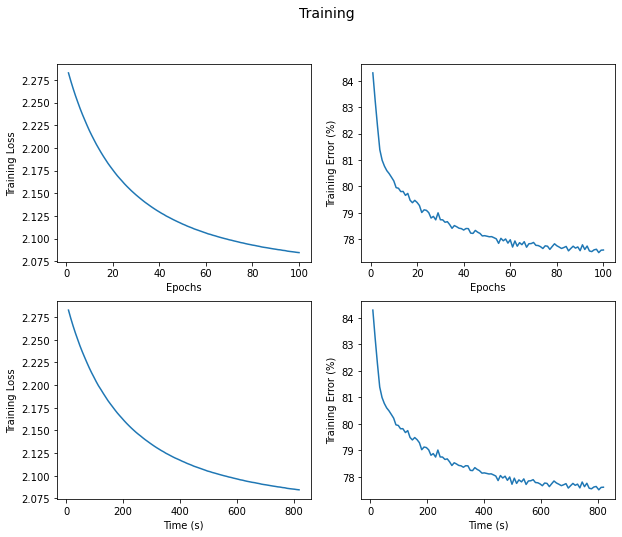

In [15]:
# Plot training

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.plot(epoch_list, train_loss_list)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

plt.subplot(2,2,2)
plt.plot(epoch_list, train_err_list)
plt.xlabel('Epochs')
plt.ylabel('Training Error (%)')

plt.subplot(2,2,3)
plt.plot(time_list, train_loss_list)
plt.xlabel('Time (s)')
plt.ylabel('Training Loss')

plt.subplot(2,2,4)
plt.plot(time_list, train_err_list)
plt.xlabel('Time (s)')
plt.ylabel('Training Error (%)')

plt.suptitle('Training', fontsize=14)
plt.show()

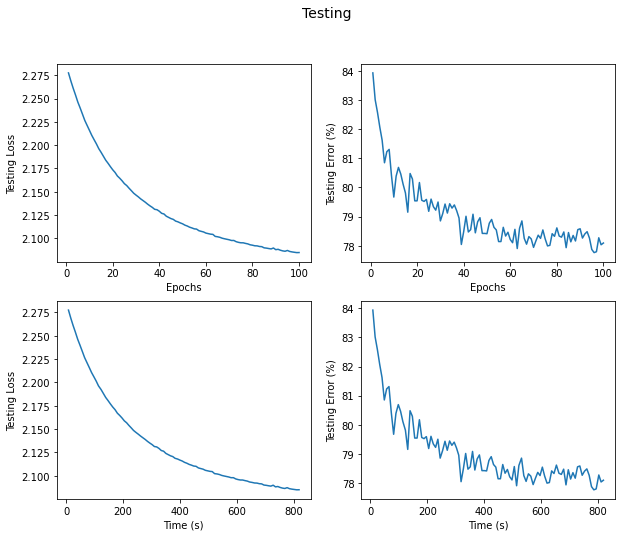

In [16]:
# Plot testing

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.plot(epoch_list, test_loss_list)
plt.xlabel('Epochs')
plt.ylabel('Testing Loss')

plt.subplot(2,2,2)
plt.plot(epoch_list, test_err_list)
plt.xlabel('Epochs')
plt.ylabel('Testing Error (%)')

plt.subplot(2,2,3)
plt.plot(time_list, test_loss_list)
plt.xlabel('Time (s)')
plt.ylabel('Testing Loss')

plt.subplot(2,2,4)
plt.plot(time_list, test_err_list)
plt.xlabel('Time (s)')
plt.ylabel('Testing Error (%)')

plt.suptitle('Testing', fontsize=14)
plt.show()

The classifier performs just as expected, bad performance. It achieves an accuracy a just little higher than random guessing. It is expected because we only used one feature, and such feature is not enough to succesfully identify and classify the numbers.

## Part c

In [17]:
# Create dataloader
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=60000,shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=10000,shuffle=True, num_workers=2)

In [18]:
images, labels = next(iter(train_dataloader))
example = images[0,:, :, :]
images = images.view(images.size(0), -1) 
mean_images = torch.mean(images, dim=1)

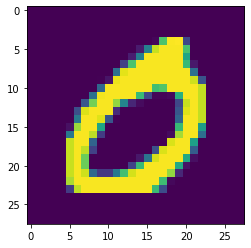

In [19]:
# Visualize example
plt.figure()
plt.imshow(example.squeeze(0))

In [20]:
# Obtain mean of the mean pixel intensity

mean_digits = {}

for i in range(10):
  data_digit = mean_images[labels == i]
  data_digit = torch.mean(data_digit)
  mean_digits[str(i)] = data_digit.item()

In [21]:
mean_digits

{'0': 0.17339932918548584,
 '1': 0.07599863409996033,
 '2': 0.14897513389587402,
 '3': 0.1415301412343979,
 '4': 0.12136559933423996,
 '5': 0.12874938547611237,
 '6': 0.13730177283287048,
 '7': 0.11452770233154297,
 '8': 0.15015597641468048,
 '9': 0.12258994579315186}

We can see the main difference in the digits 0 and 1. For 1 we get the lowest mean intensity which is expected because the number 1 does not occupy a lot of area from the background. On the other hand, we have zero, with the highest mean intensity, which is also expected for the same reason, it occupies much more area than the other digits.

## Part d

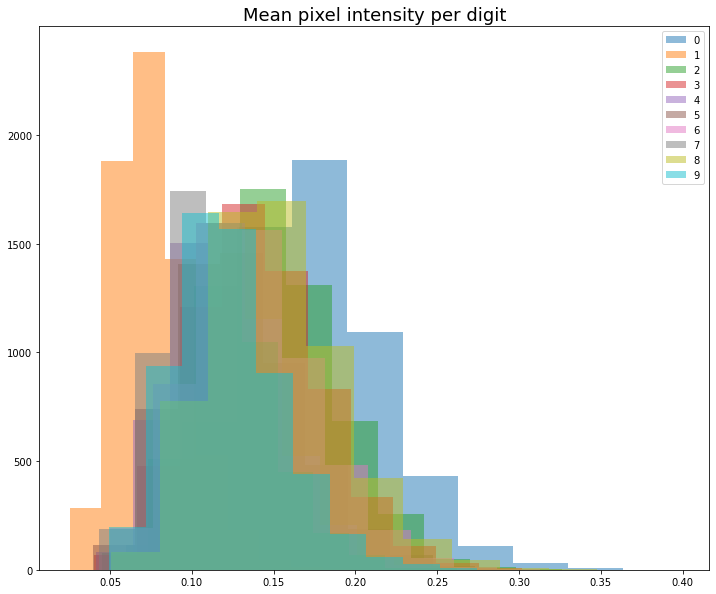

In [22]:
# Create histograms

plt.figure(figsize=(12, 10))
for i in range(10):
  data_digit = mean_images[labels == i]
  plt.hist(data_digit, alpha=0.5, label=str(i))
plt.legend(loc='upper right')
plt.title('Mean pixel intensity per digit', fontsize=18)
plt.show()

Yes, again, 0 and 1. The distribution of 1 is shifted towards the lower bins, while the distribution of 0 is shifted towards the highest bins, which is the expected behavior.

## Part e

I do not think adding this feature would help to improve the classifier in Problem 2 given that it does not represent a significant difference between the digits, so adding it among the other 784 features would not help the classifier to identify the different classes, hence it would not represent a major change in the peformance.